In [1]:
# !pip install numpy==1.23.5
import matplotlib.pyplot as plt
import os
import sys

args = 6
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

Selected GPU 6
Jax version:         0.4.16
Python version:      3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
Jax default backend: gpu
Jax devices:         [gpu(id=0)]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('/home/davcic/CP_Testing')
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic


In [4]:
base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()

# kernel = Discontinuous_multiple_params_hyper(base_kernel)
kernel = Discontinuous_multiple_params_hyper(base_kernel1) + Discontinuous_multiple_params_hyper_periodic(base_kernel2)
test = kernel.kernel_set
isinstance(kernel, jk.base.CombinationKernel)
test[0].name

'RBF'

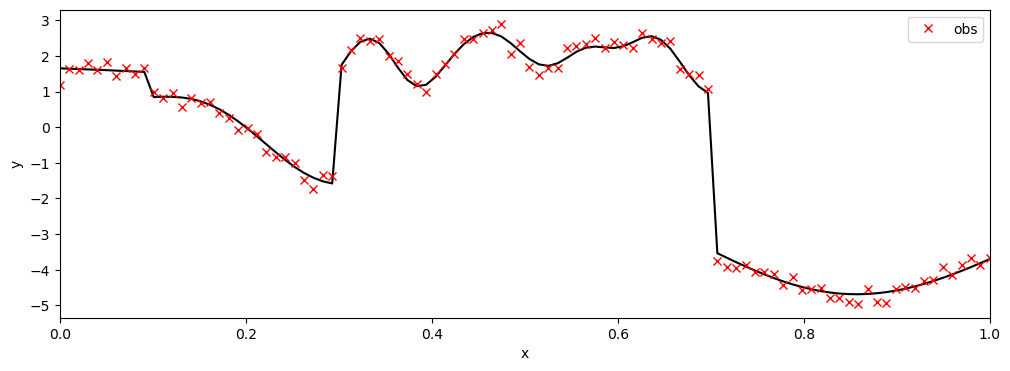

In [5]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_,
                    num = x0)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [7]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(
                          # lengthscale=Uniform_mod(low = jnp.zeros(max_CP+1),
                          #                        high = jnp.zeros(max_CP+1)+1),
                          # variance=Uniform_mod(low = jnp.zeros(max_CP+1),
                          #                        high = jnp.zeros(max_CP+1)+5),
                          lengthscale=LogNormal_mod(0, 3, max_CP+1),
                          variance=LogNormal_mod(0.5, 1, max_CP+1), 
                        #   lengthscale=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                                  jnp.eye(max_CP)), 
                        #                              dx.Block(tfb.Exp(), 1)),
                        #   variance=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                               jnp.eye(max_CP)),
                        #                           dx.Block(tfb.Exp(), 1)),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_pp = LogNormal_mod(0, 1, 1)))


### GP Class

### Marginal GP

In [8]:
from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1_000
num_mcmc_steps = 100
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [19]:
# from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel
# marginal_GP = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)

In [9]:
jnp.save('test_GP.npy', GP_marginal)

In [14]:
test = jnp.load('test_GP.npy', allow_pickle= True)[()]

Array([[0.        ],
       [0.01010101],
       [0.02020202],
       [0.03030303],
       [0.04040404],
       [0.05050505],
       [0.06060606],
       [0.07070707],
       [0.08080808],
       [0.09090909],
       [0.1010101 ],
       [0.11111111],
       [0.12121212],
       [0.13131313],
       [0.14141414],
       [0.15151515],
       [0.16161616],
       [0.17171717],
       [0.18181818],
       [0.19191919],
       [0.2020202 ],
       [0.21212121],
       [0.22222222],
       [0.23232323],
       [0.24242424],
       [0.25252525],
       [0.26262626],
       [0.27272727],
       [0.28282828],
       [0.29292929],
       [0.3030303 ],
       [0.31313131],
       [0.32323232],
       [0.33333333],
       [0.34343434],
       [0.35353535],
       [0.36363636],
       [0.37373737],
       [0.38383838],
       [0.39393939],
       [0.4040404 ],
       [0.41414141],
       [0.42424242],
       [0.43434343],
       [0.44444444],
       [0.45454545],
       [0.46464646],
       [0.474

: 

In [28]:
GP_marginal.model_GP(key)

Running Marginal GP
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01


In [26]:
# jnp.save('test_GP_particles.npy', [GP_marginal.particles.particles])

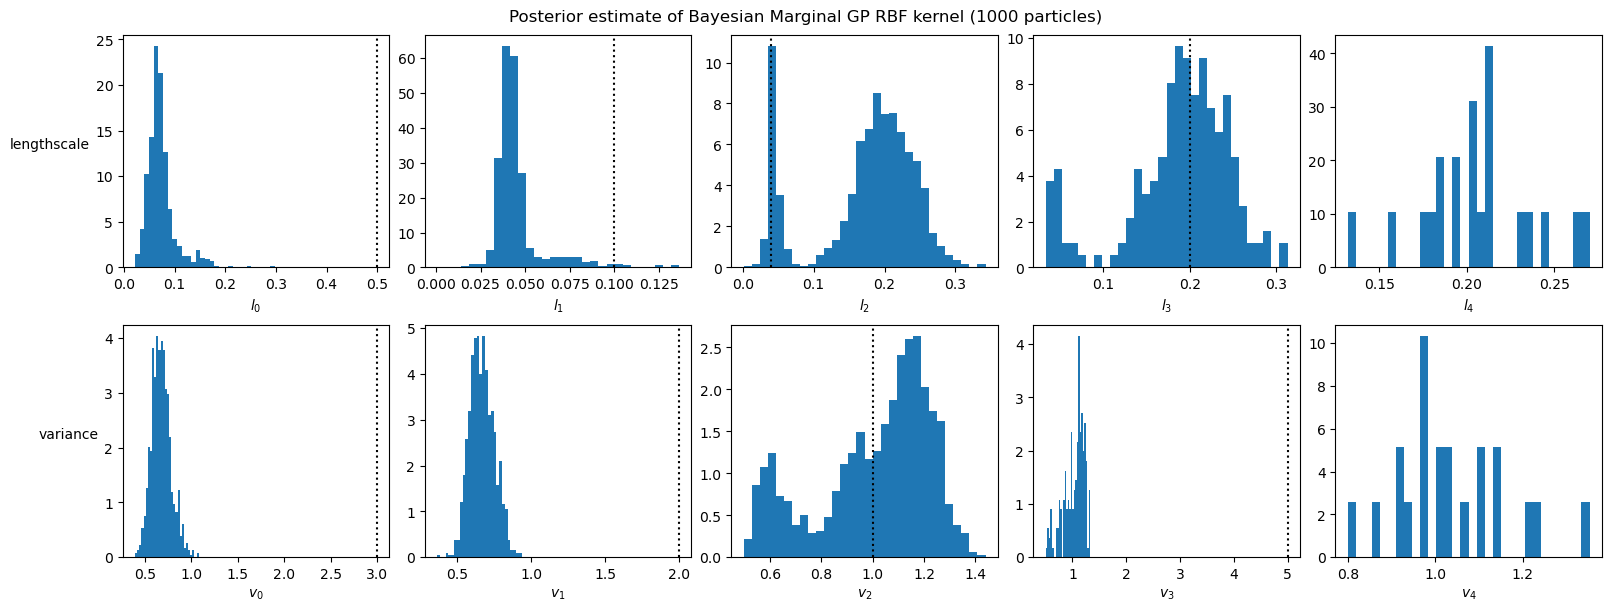

In [29]:
GP_marginal.plot_post(ground_truth)

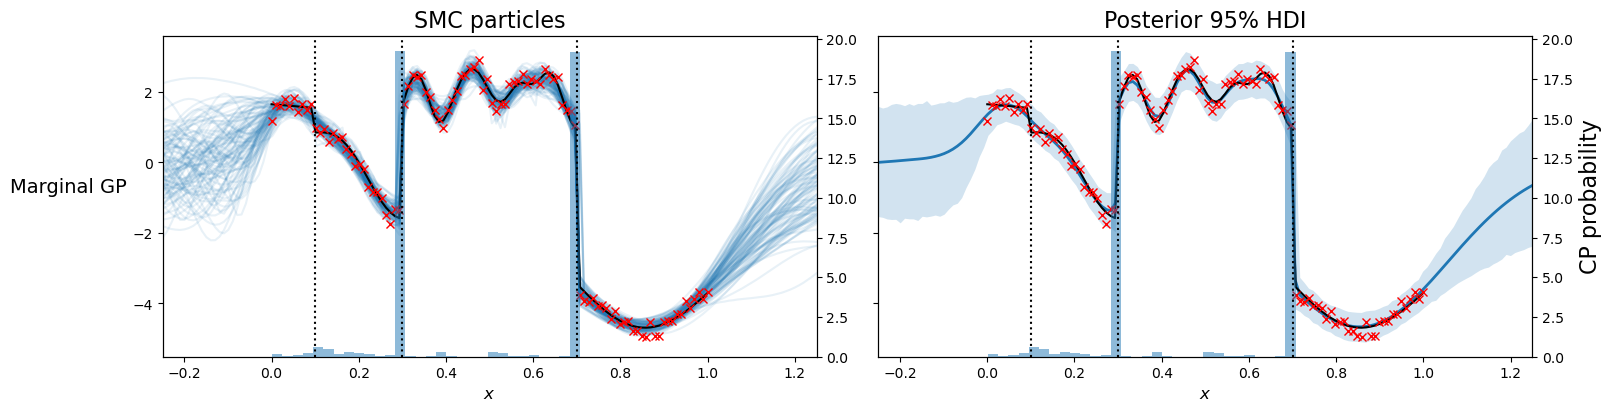

In [30]:
GP_marginal.plot_fit(key, True, f_true, ground_truth)

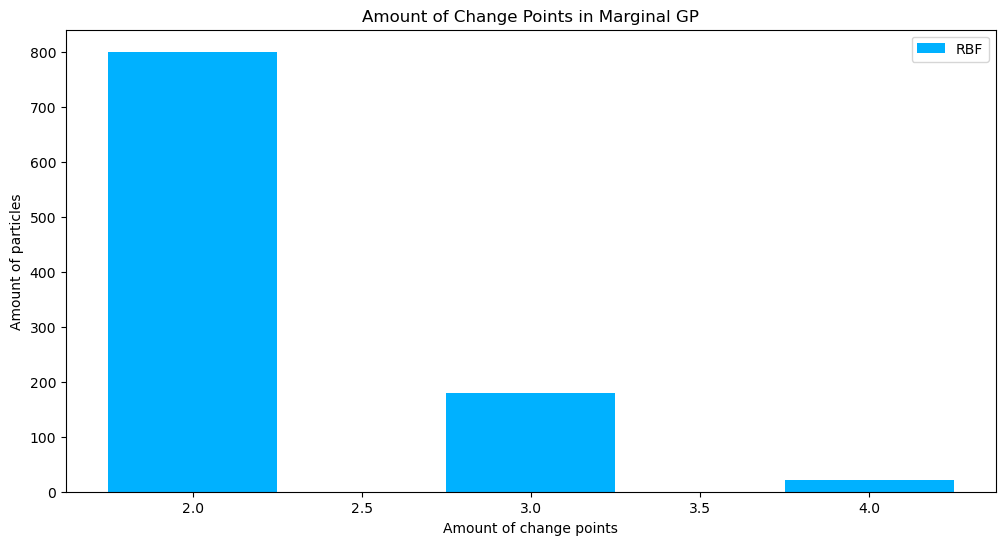

In [31]:
GP_marginal.plot_num()

In [32]:
print(GP_marginal.number_metric(ground_truth))
print(GP_marginal.location_metric(ground_truth))
print(GP_marginal.likelihood_metric(key))
print(GP_marginal.jaccard_metric(ground_truth))

-0.11128571428571428
0.13580000000000003
33.67625681531956
0.28053809523809514


In [40]:
print(GP_marginal.likelihood)

-51.0103275593283


In [52]:
size = len(y)
x_pred = jnp.linspace(-0, 1, num=size)
key, key_pred = jrnd.split(key)
f_pred = GP_marginal.gp_fit.predict_f(key_pred, x_pred)

f_mean = jnp.nanmean(f_pred, axis=0)
cov = jnp.mean(GP_marginal.particles.particles['likelihood']['obs_noise'])

Test = dx.Normal(loc=f_mean, scale=cov)
jnp.sum(Test.log_prob(y))

Array(33.8487678, dtype=float64)

In [62]:
from typing import Any, Union, NamedTuple, Dict, Any, Iterable, Mapping, Callable
from jaxtyping import Float
from jax import Array
from jax.tree_util import tree_flatten, tree_unflatten

ArrayTree = Union[Array, Iterable["ArrayTree"], Mapping[Any, "ArrayTree"]]
class GibbsState(NamedTuple):

    position: ArrayTree

val = GP_marginal.gp_fit.loglikelihood_fn()

priors_flat, priors_treedef = tree_flatten(GP_marginal.particles.particles)
# print(priors_flat)
first_values = [item[0] for item in priors_flat]
# print(first_value/s)

position = tree_unflatten(priors_treedef, first_values)
# position = dict(zip(names, first_values))
# print(position)
val(GibbsState(position))

{'lengthscale': Array([0.06549879, 0.075167  , 0.04113853, 0.26662977,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan], dtype=float64), 'num': Array([0.1141105 , 0.29922783, 0.70006334,        nan,        nan,
              nan,        nan,        nan,        nan,        nan],      dtype=float64), 'variance': Array([0.66883249, 0.62857757, 0.57897123, 1.0229548 ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan], dtype=float64)}


Array(-33.75639183, dtype=float64)

### Latent GP

In [33]:
from GP_CP import GP_CP_Marginal, GP_CP_Latent

num_particles = 1_000
num_mcmc_steps = 1000
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [35]:
GP_latent.model_GP(key)

Running Latent GP


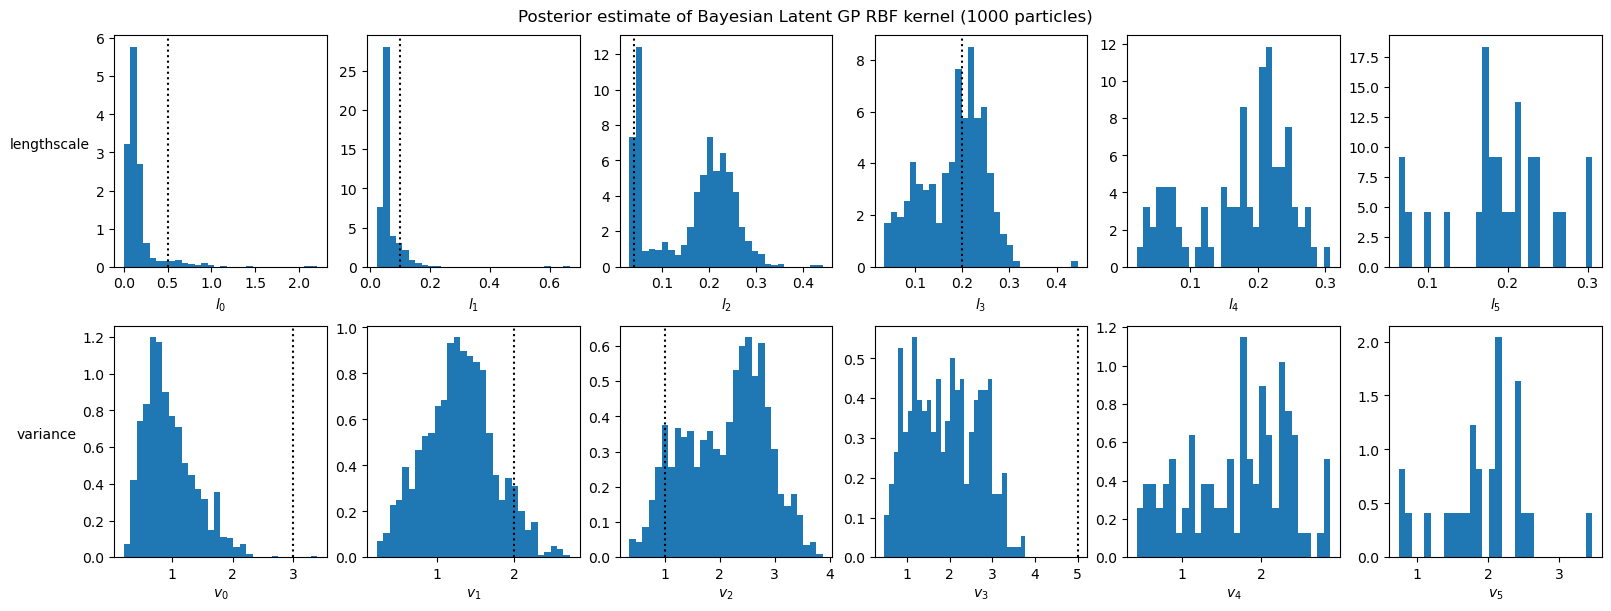

In [37]:
GP_latent.plot_post(ground_truth)

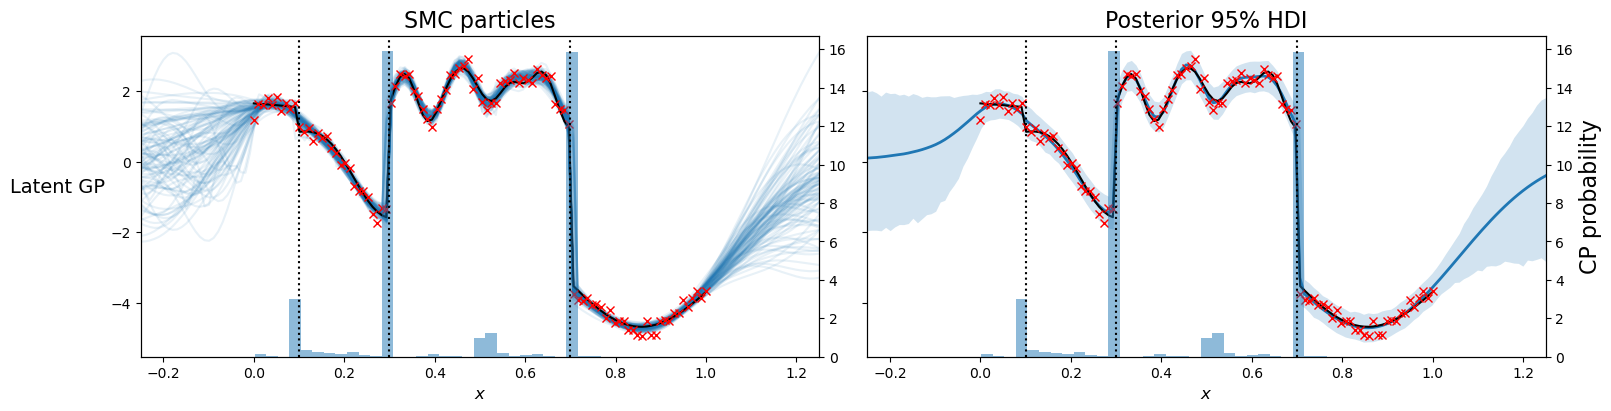

In [38]:
GP_latent.plot_fit(key, True, f_true, ground_truth)

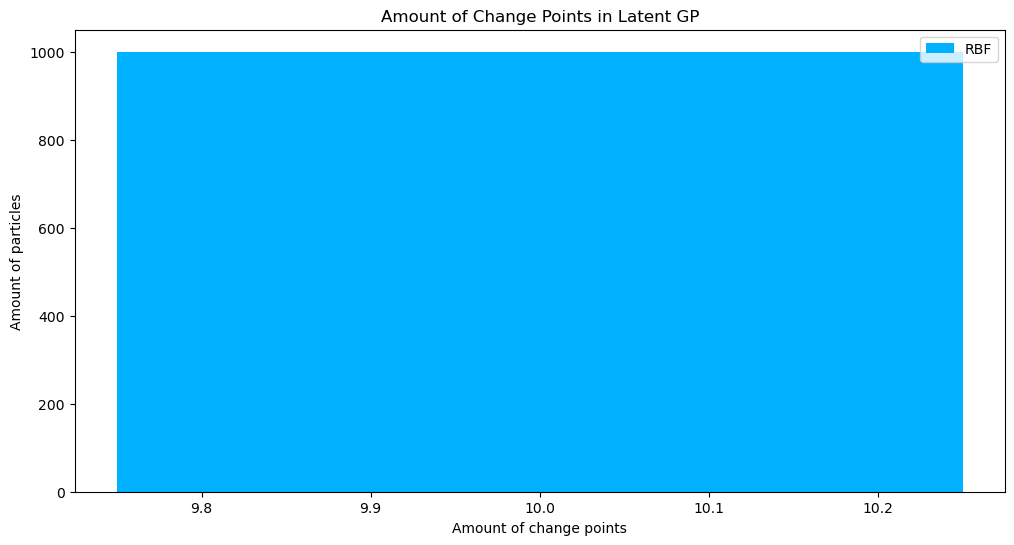

In [ ]:
GP_latent.plot_num()

In [38]:
print(GP_latent.number_metric(ground_truth))
print(GP_latent.location_metric(ground_truth))
print(GP_latent.likelihood_metric(key))
print(GP_latent.jaccard_metric(ground_truth))

1.0
0.29999999999999993
45.21633788872123
0.14660416666666665


In [39]:
print(GP_latent.likelihood)

-84.04906763574081


In [15]:
size = len(y)
x_pred = jnp.linspace(-0, 1, num=size)
key, key_pred = jrnd.split(key)
f_pred = GP_latent.gp_fit.predict_f(key_pred, x_pred)

f_mean = jnp.nanmean(f_pred, axis=0)
cov = jnp.mean(GP_latent.particles.particles['likelihood']['obs_noise'])

Test = dx.Normal(loc=f_mean, scale=cov)
jnp.sum(Test.log_prob(y))

NameError: name 'GP_latent' is not defined

### Optimal GP Likelihood

Array(34.94517082, dtype=float64)

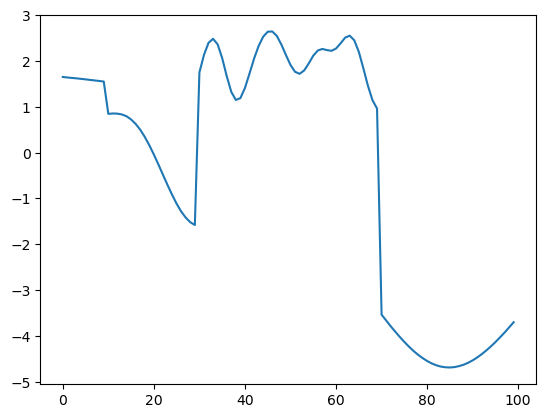

In [19]:
size = len(y)
x_pred = jnp.linspace(-0, 1, num=size)
key, key_pred = jrnd.split(key)
kernel = Discontinuous_multiple_params_hyper(base_kernel)

mu = jnp.zeros(100)
cov = kernel.cross_covariance(  params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                                x=x, y=x)+ 1e-6*jnp.eye(n)

dist = dx.MultivariateNormalFullCovariance(mu, cov)

# f_pred = dist.sample(seed=key, sample_shape=100)

f_mean = f_true
cov = ground_truth['obs_noise']

plt.plot(f_mean)

Test = dx.Normal(loc=f_mean, scale=cov)
jnp.sum(Test.log_prob(y))

### Testing combined kernels

In [ ]:
key = jrnd.PRNGKey(123456)

base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()

# kernel = Discontinuous_multiple_params_hyper(base_kernel)
kernel = Discontinuous_multiple_params_hyper(base_kernel1) + Discontinuous_multiple_params_hyper_periodic(base_kernel2)

key, key1 = jrnd.split(key)
lengthscale1 = jnp.array([0.1, 1])
variance1 = jnp.array([2, 1])
lengthscale2 = jnp.array([0.4, 0.5])
variance2 = jnp.array([0.5, 2])
period = jnp.array([0.2, 0.3])
num1 = jnp.array([0.5])
num2 = jnp.array([0.3])

# params = dict(kernel1 =dict(lengthscale= lengthscale1,
#                             variance = variance1,
#                             num = num), 
#               kernel2 =dict(lengthscale= lengthscale2,
#                             variance = variance2,
#                             period = period, 
#                             num = num))
params = [dict(lengthscale= lengthscale1,
                            variance = variance1,
                            num = num1), 
              dict(lengthscale= lengthscale2,
                            variance = variance2,
                            period = period, 
                            num = num2)]
x = jnp.linspace(0, 1, 100)


K = kernel.cross_covariance(params, x, x)
# plt.imshow(K)
# plt.show()

n = 100
obs_noise_ = 0.3
L = jnp.linalg.cholesky(K+ 1e-6*jnp.eye(n))
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))


ground_truth = [dict(f=f_true,
                    lengthscale=lengthscale1,
                    variance=variance1,
                    obs_noise=obs_noise_, 
                    num = num1), 
                dict(f=f_true,
                    lengthscale=lengthscale2,
                    variance=variance2,
                    period = period,
                    obs_noise=obs_noise_, 
                    num = num2)]


plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.show()

In [ ]:
num_particles = 1_000
num_mcmc_steps = 100
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)